In [1]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta

# Load dataset

In [2]:
ts60 = pd.read_csv('../../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Diff Load Activa Total (60 minuto)'].dropna()
load60.head()


datetime
2020-11-06 00:00:00    2600.0
2020-11-06 01:00:00    2610.0
2020-11-06 02:00:00    2570.0
2020-11-06 03:00:00    2580.0
2020-11-06 04:00:00    2600.0
Name: Diff Load Activa Total (60 minuto), dtype: float64

# Train / Test

In [3]:
last_train_day = datetime(2021, 6, 20)
train = load60[:(last_train_day - timedelta(hours=1))]  
train = train.asfreq('H')
test = load60[last_train_day:]
test = test.asfreq('H')

# Config
Steps for day ahead forecasts are preset to 24 (1 day)

In [4]:
steps = 24
days_ahead = 11

# Load model from disk

In [5]:
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__

sarima = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('../../VEOLIA/models/tal_sarima.pkl')
print(sarima.summary())

FileNotFoundError: [Errno 2] No such file or directory: '../VEOLIA/models/tal_sarima.pkl'

# Day ahead forecast 

1 day ahead forecast:
MAPE: 0.11836845951583158
MSE: 128549.33198527143
RMSE: 358.5377692590718


<Figure size 432x288 with 0 Axes>

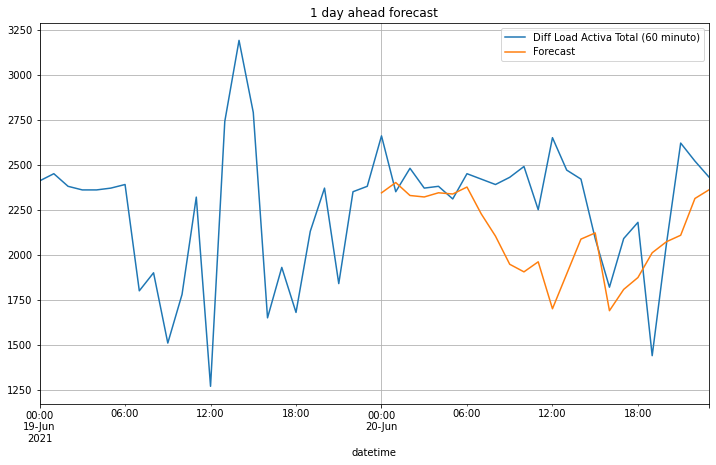

In [ ]:
forecast_sarima = sarima.get_forecast(steps=steps)
predictions = forecast_sarima.summary_frame()['mean'].values
ground_truth = test[:steps]

# 1 day ahead forecast evaluation
print("1 day ahead forecast:")
print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

comparison_sarima = pd.DataFrame(ground_truth)
comparison_sarima['Forecast'] = predictions
training = pd.DataFrame(train, columns=comparison_sarima.filter(like='Diff').columns.tolist())
comparison_sarima = pd.concat([training, comparison_sarima])

plt.figure()
plot = comparison_sarima[datetime(2021, 6, 19):].plot(figsize=(12,7), 
                         title="1 day ahead forecast")
plot.grid()


# Simple 11-day ahead forecast with error propagation


Simple 11 day ahead forecast:
MAPE: 0.11972988816988364
MSE: 103081.85389998072
RMSE: 321.0636290519073


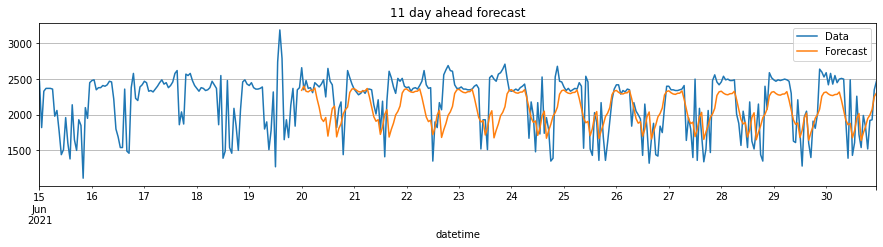

In [ ]:
print(f"Simple {days_ahead} day ahead forecast:")
predictions = sarima.forecast(steps * days_ahead)
ground_truth_line = pd.concat([train[-5*24:], test])

print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()

# Advanced 11-day ahead forecast with news update every 24h (no refitting)


Advanced 11 day ahead forecast:
Advanced 11 day ahead forecast:
MAPE: 0.12683560575512076
MSE: 100159.56125081875
RMSE: 316.4799539478271


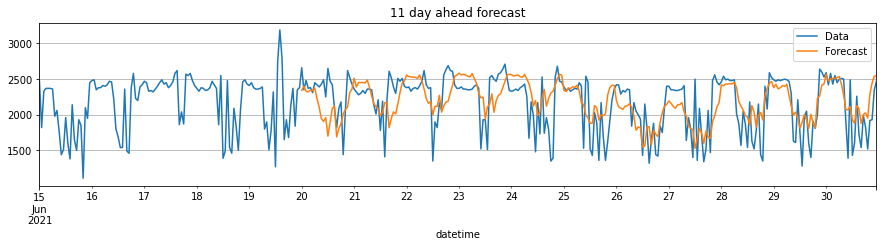

In [ ]:
print(f"Advanced {days_ahead} day ahead forecast:")
ground_truth_line = pd.concat([train[-5*24:], test])

predictions = pd.Series(dtype='float64')
for n_day in range(days_ahead):
    cur_timestep = n_day * steps
    next_timestep =  cur_timestep + steps
    day_preds = sarima.forecast(steps)
    predictions = pd.concat([predictions, day_preds])
    y_news = test.iloc[cur_timestep: next_timestep]
    y_news = y_news.asfreq('H')
    sarima = sarima.append(y_news)

predictions.name = test.name
predictions = predictions.rename_axis('datetime')

# Evaluation metrix
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

# Plot the last 5 days of data and the 11 days of forecast
plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"Advanced {days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()
